In [90]:
import matplotlib.pyplot as plt
from keras.models import load_model, Model
import numpy as np
from utils.visualizations import GradCAM, GuidedGradCAM, GBP, LRP, CLRP, SGLRP, SGLRP2, OAGLRP
from utils.helper import heatmap
import innvestigate.utils as iutils
from innvestigate.analyzer import PatternAttribution
import os
from keras.preprocessing.image import img_to_array, load_img

os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [91]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [92]:
# This will be your trained model instead.

from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
model = VGG19(
# from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
# model = VGG16(
    weights='imagenet', include_top=False
)
# model.summary()
basemodel = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
for layer in model.layers:
             layer.trainable = False

conv_last = basemodel.output
conv_last = GlobalAveragePooling2D()(conv_last)
out = Dense(, activation='softmax')(conv_last)

In [93]:
# Only the partial model is needed for the visualizers. Use innvestigate.utils.keras.graph.pre_softmax_tensors()
partial_model = Model(
    inputs=model.inputs,
    outputs=iutils.keras.graph.pre_softmax_tensors(model.outputs),
    name=model.name,
)
partial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [94]:
# Range of input images
# keras_applications VGG16 weights assume a range of (-127.5, 127.5). Change this to a range suitable for your model.
max_input = -127.5
min_input = 127.5

In [95]:
# Change this to load a list of images you want. For this example, we are only loading one image, but you can load a list of files.
orig_imgs = [img_to_array(load_img("data/coco/val2017-center-crop-224x224/000000097022.jpg", target_size=(224, 224)))] 
input_imgs = np.copy(orig_imgs)
print(np.shape(input_imgs))

# preprocess input for model
input_imgs = preprocess_input(input_imgs) #for built in keras models

(1, 224, 224, 3)


In [96]:
# Select only one from your list for example
example_id = 0

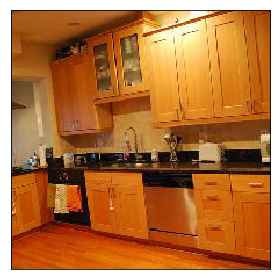

In [97]:
plt.imshow(orig_imgs[example_id].astype(int))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [98]:
# Which class you want to target.
target_class = 651 # ImageNet "zebra"

# GradCAM and GuidedGradCAM requires a specific layer
target_layer = "block5_pool" # VGG only

In [99]:
# Optional
predictions = model.predict(input_imgs)
pred_id = np.argmax(predictions[example_id])
print(decode_predictions(predictions))
print("prediction id:", pred_id)
print("target id:", target_class)

[[('n03761084', 'microwave', 0.6713376), ('n03207941', 'dishwasher', 0.31175053), ('n04330267', 'stove', 0.0044748154), ('n03961711', 'plate_rack', 0.004066567), ('n04070727', 'refrigerator', 0.0035965582)]]
prediction id: 651
target id: 651


# GradCAM

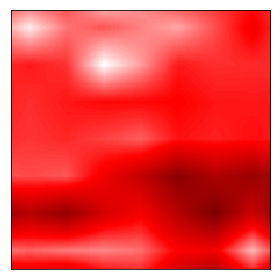

In [100]:
partial_gradcam_analyzer = GradCAM(
    model=partial_model,
    target_id=target_class,
    layer_name=target_layer,
    relu=True,
)
analysis_partial_grad_cam = partial_gradcam_analyzer.analyze(input_imgs)
heatmap(analysis_partial_grad_cam[example_id].sum(axis=(2)))
plt.show()

# Guided Back Propagation

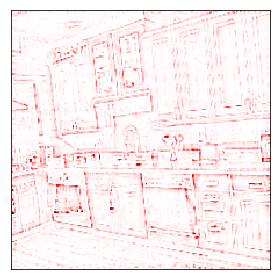

In [85]:
guidedbackprop_analyzer = GBP(
    partial_model,
    target_id=target_class,
    relu=True,
)
analysis_guidedbackprop = guidedbackprop_analyzer.analyze(input_imgs)
heatmap(analysis_guidedbackprop[example_id].sum(axis=(2)))
plt.show()

# GuidedGradCAM

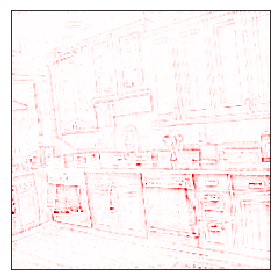

In [86]:
guidedgradcam_analyzer = GuidedGradCAM(
    partial_model,
    target_id=target_class,
    layer_name=target_layer,
    relu=True,
)
analysis_guidedgradcam = guidedgradcam_analyzer.analyze(input_imgs)
heatmap(analysis_guidedgradcam[example_id].sum(axis=(2)))
plt.show()

# LRP

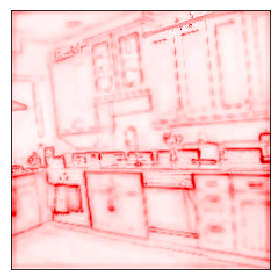

In [87]:
lrp_analyzer = LRP(
    partial_model,
    target_id=target_class,
    relu=True,
    low=min_input,
    high=max_input,
)
analysis_lrp = lrp_analyzer.analyze(input_imgs)
heatmap(analysis_lrp[example_id].sum(axis=(2)))
plt.show()

# CLRP

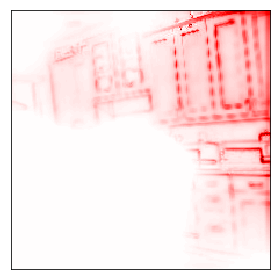

In [88]:
clrp_analyzer = CLRP(
    partial_model,
    target_id=target_class,
    relu=True,
    low=min_input,
    high=max_input,
)
analysis_clrp = clrp_analyzer.analyze(input_imgs)
heatmap(analysis_clrp[example_id].sum(axis=(2)))
plt.show()

# SGLRP

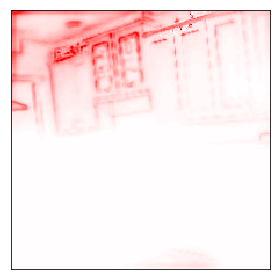

In [89]:
sglrp_analyzer = SGLRP(
    partial_model,
    target_id=target_class,
    relu=True,
    low=min_input,
    high=max_input,
)
analysis_sglrp = sglrp_analyzer.analyze(input_imgs)
heatmap(analysis_sglrp[example_id].sum(axis=(2)))
plt.show()

In [17]:
# oaglrp_analyzer = OAGLRP(
#     partial_model,
#     target_id=target_class,
#     relu=False,
#     scaling=False,
#     low=min_input,
#     high=max_input,
# )
# analysis_oaglrp = oaglrp_analyzer.analyze(input_imgs)
# heatmap(analysis_oaglrp[example_id].sum(axis=(2)))
# plt.show()

In [101]:
pattern_analyzer = PatternAttribution(
    partial_model,
)
analysis_pattern = pattern_analyzer.analyze(input_imgs)
heatmap(analysis_pattern[example_id].sum(axis=(2)))
plt.show()

TypeError: object of type 'NoneType' has no len()